## Sentiment analysis implementation

### Key steps: 

- Textual preprocessing 
- TextBlob implementation
- Evaluation of model

---

### Textual Preprocessing ###

Steps: 
- Efficiency: SpaCy is known for its speed and memory efficiency. It's designed to be fast and suitable for production environments where processing large amounts of text is required.

- Pre-trained Models: SpaCy provides pre-trained models for various languages that are capable of performing tasks like named entity recognition, part-of-speech tagging, and more. These models can be fine-tuned for specific applications.

- Tokenization: SpaCy efficiently splits text into individual words or tokens. This process is a fundamental step in NLP, as many subsequent tasks rely on having correctly segmented text.

- Part-of-Speech Tagging: The library can tag words in a sentence with their corresponding parts of speech, such as nouns, verbs, adjectives, etc.

- Named Entity Recognition (NER): SpaCy can identify and classify entities in text, such as names of people, organizations, locations, dates, and more.

- Dependency Parsing: Dependency parsing involves determining the grammatical relationships between words in a sentence. SpaCy can create dependency parse trees that represent these relationships.

- Lemmatization: SpaCy can transform words to their base or dictionary form (lemmas), which is useful for reducing words to their core meaning.

In [ ]:
## Importing libraries 

import pandas as pd
import numpy as np
import spacy
from textblob import TextBlob

# For train/test splits, metrics, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS




In [3]:
df = pd.read_csv("cleaned_glassdoor_reviews.csv")  
df.head()

,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,Management,Post Title,Pros,Cons,pros_length,cons_length,Review_Combined,Review_Clean
0,AFH-Wealth-Management,2015-04-05,,Unknown,2,4,3,4,2,3,3,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",10,6,Very friendly and welcoming to new staff. Easy...,friendly welcome new staff easy go ethic poor ...
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Bromsgrove, England, England",2,3,1,4,2,1,4,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,5,19,"Friendly, helpful and hard-working colleagues ...",friendly helpful hard work colleague poor sala...
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Bromsgrove, England, England",1,1,1,4,1,1,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",10,33,Easy to get the job even without experience in...,easy job experience finance low salary poor wo...
3,AFH-Wealth-Management,2016-04-16,,Unknown,5,2,3,4,2,2,3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,5,7,Nice staff to work with No career progression ...,nice staff work career progression salary poor
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Bromsgrove, England, England",1,2,1,4,2,1,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",7,41,"Easy to get the job, Nice colleagues. Abysmal ...",easy job nice colleague abysmal pay minimum wa...


Implementing SpaCy

In [4]:
import re

def clean_text(text):
    text = str(text)  # ensure it's a string
    text = text.encode("ascii", "ignore").decode()  # remove non-ASCII characters
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces/newlines/tabs
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", text)  # remove other characters
    text = text.strip()  # trim leading/trailing whitespace
    return text

In [5]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Tokenize the text, and remove punctuation and stop words, lowercase and lemmatize the text, and return
# the remaining tokens as a list
def spacy_tokenizer(text, batch_size=500):
    result = []
    cleaned_texts = [clean_text(t) for t in text]  # Clean the texts first
    
    for doc in nlp.pipe(text, disable=["parser", "ner"], batch_size=batch_size):
        tokens = [
            token.lemma_.lower().strip() 
            for token in doc 
            if not token.is_stop and not token.is_punct and not token.like_num
        ]
        result.append(" ".join(tokens))
    return result

# Combine Pros and Cons first 
df["Review_Combined"] = df["Pros"].fillna("") + " " + df["Cons"].fillna("")

# Run tokenizer on combined reviews
df["Review_Clean"] = spacy_tokenizer(df["Review_Combined"].astype(str).tolist(), batch_size=500)



In [ ]:
df.to_csv("cleaned_glassdoor_reviews.csv", index=False)

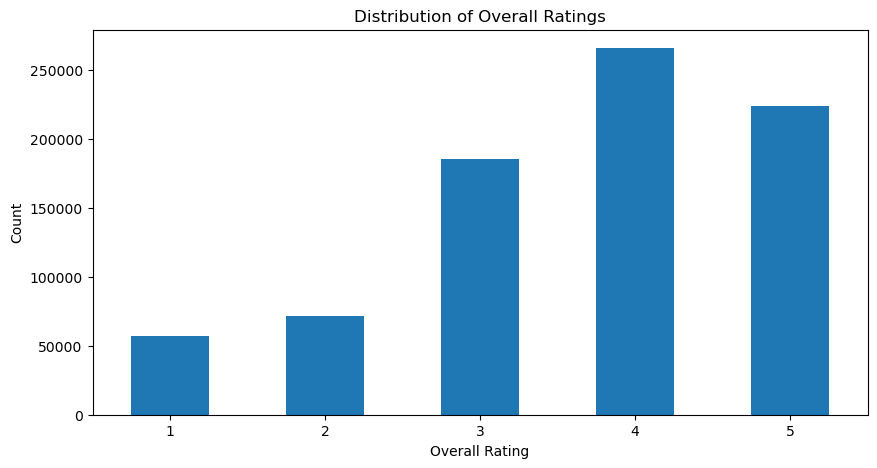

In [7]:
# Check distribution of overall ratings on full dataset
df["Overall Rating"].value_counts().sort_index().plot(kind="bar", figsize=(10, 5))
plt.title("Distribution of Overall Ratings")
plt.xlabel("Overall Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


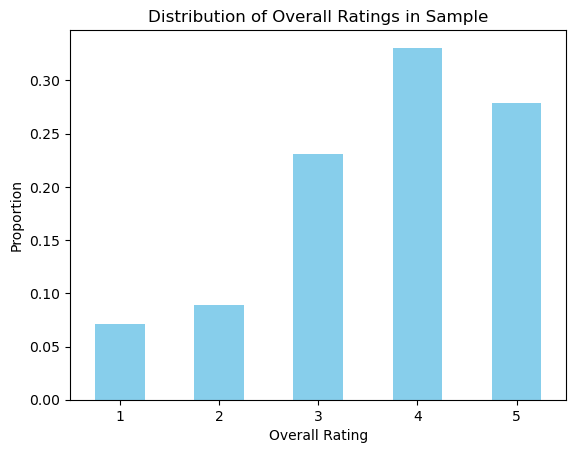

In [8]:
# sample the dataset using stratified sampling
# Stratified sampling to ensure each class is represented
# in the sample according to its proportion in the full dataset
df_sample, _ = train_test_split(df, train_size=5000, stratify= df["Overall Rating"], random_state=42)

# check the distribution of the sample
df_sample["Overall Rating"].value_counts(normalize=True).sort_index().plot(kind="bar", color="skyblue")
plt.title("Distribution of Overall Ratings in Sample")
plt.xlabel("Overall Rating")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

# save the sampled data
df_sample.to_csv("sampled_glassdoor_reviews.csv", index=False)

In [ ]:

# implement the TextBlob sentiment analysis
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply to Pros and Cons columns
df_sample["TextBlob_Score"] = df_sample["Review_Clean"].apply(textblob_sentiment)

df_sample.head(10)



,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,Management,Post Title,Pros,Cons,pros_length,cons_length,Review_Combined,Review_Clean,TextBlob_Score
441685,KPMG,2021-03-01,Associate,"New York, NY",4,2,4,4,4,3,4,Good & bad,Great environment for career growth,Long hours - really long hours,5,6,Great environment for career growth Long hours...,great environment career growth long hour long...,0.233333
439528,KPMG,2020-12-23,Advisory Associate,"Santa Clara, CA",4,3,3,4,3,3,3,Flexible firm with good people,I love the people I work with and the firm has...,"Pay and hours, but there is a lot of upward mo...",15,11,I love the people I work with and the firm has...,love people work firm flexible pay hour lot up...,0.150000
447028,Korn-Ferry,2019-06-17,Talent Acquisition Specialist,"Auckland, Auckland",4,4,4,4,4,2,4,"Overall, a positive experience","Plenty of opportunities to grow your career, a...","Below market salaries, a lot of additional adm...",22,11,"Plenty of opportunities to grow your career, a...",plenty opportunity grow career supportive frie...,0.437500
196380,Deloitte,2020-06-23,Anonymous Employee,Unknown,4,3,3,4,3,3,3,great place to grow your career,offers great learning opportunities through it...,long hours + travel; changing expectations,15,6,offers great learning opportunities through it...,offer great learn opportunity apprenticeship m...,0.516667
591022,Oracle,2013-07-04,Senior Field Support Engineer,"Houston, TX",3,4,3,4,3,5,3,Okay to work for,Great benefits. They really know their stuff ...,Company does not seem to understand hardware s...,15,8,Great benefits. They really know their stuff ...,great benefit know stuff come well company un...,0.800000
266212,GlaxoSmithKline,2020-01-29,Senior Director Marketing,Buenos Aires,4,4,4,4,5,4,4,In charge of the Vaccines private and public b...,"Great R&D, pipeline. Values based company.",Resilience in front of continuous structure ch...,6,7,"Great R&D, pipeline. Values based company. Res...",great r&d pipeline value base company resilien...,0.000000
683077,SAP,2013-11-23,Vice President,Singapore,5,5,5,4,5,5,3,Great company with strong employee centric cul...,"Smart people, high employee engagement, strong...","not always great leaders, stop&go approach to ...",11,8,"Smart people, high employee engagement, strong...",smart people high employee engagement strong e...,0.321524
673439,Radisson-Hotel-Group,2021-05-08,Human Resources Manager,Mumbai,5,5,5,5,5,5,4,review,good company to work with,less work life balance overall,5,5,good company to work with less work life balan...,good company work work life balance overall,0.350000
728860,Tesco,2020-09-03,Retail Assistant,"Peterborough, England, England",4,3,3,4,4,4,4,Good,Easy and enjoyable tasks at the job.,Sometimes you got customers that were rude.,7,7,Easy and enjoyable tasks at the job. Sometimes...,easy enjoyable task job get customer rude,0.211111
551513,Microsoft,2017-10-20,Software Engineer,"Redmond, WA",3,5,3,4,4,4,2,It's laid back but tedious,"Laid back, not many hours, slow, can move pret...",Pay is only ok. Slow. You often find everythin...,20,24,"Laid back, not many hours, slow, can move pret...",lay hour slow pretty easily want word word pay...,0.116667


In [ ]:
def polarity_to_label(score):
    if score > 0.45:
        return 5
    elif score > 0.25:
        return 4
    elif score > 0.05:
        return 3
    elif score > -0.2:
        return 2
    else:
        return 1

# Apply the function to the TextBlob_Score column

df_sample["TextBlob_Rating"] = df_sample["TextBlob_Score"].apply(polarity_to_label)


df_sample.head(30)



,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,Management,Post Title,Pros,Cons,pros_length,cons_length,Review_Combined,Review_Clean,TextBlob_Score,TextBlob_Rating
441685,KPMG,2021-03-01,Associate,"New York, NY",4,2,4,4,4,3,4,Good & bad,Great environment for career growth,Long hours - really long hours,5,6,Great environment for career growth Long hours...,great environment career growth long hour long...,0.233333,3
439528,KPMG,2020-12-23,Advisory Associate,"Santa Clara, CA",4,3,3,4,3,3,3,Flexible firm with good people,I love the people I work with and the firm has...,"Pay and hours, but there is a lot of upward mo...",15,11,I love the people I work with and the firm has...,love people work firm flexible pay hour lot up...,0.150000,3
447028,Korn-Ferry,2019-06-17,Talent Acquisition Specialist,"Auckland, Auckland",4,4,4,4,4,2,4,"Overall, a positive experience","Plenty of opportunities to grow your career, a...","Below market salaries, a lot of additional adm...",22,11,"Plenty of opportunities to grow your career, a...",plenty opportunity grow career supportive frie...,0.437500,4
196380,Deloitte,2020-06-23,Anonymous Employee,Unknown,4,3,3,4,3,3,3,great place to grow your career,offers great learning opportunities through it...,long hours + travel; changing expectations,15,6,offers great learning opportunities through it...,offer great learn opportunity apprenticeship m...,0.516667,5
591022,Oracle,2013-07-04,Senior Field Support Engineer,"Houston, TX",3,4,3,4,3,5,3,Okay to work for,Great benefits. They really know their stuff ...,Company does not seem to understand hardware s...,15,8,Great benefits. They really know their stuff ...,great benefit know stuff come well company un...,0.800000,5
266212,GlaxoSmithKline,2020-01-29,Senior Director Marketing,Buenos Aires,4,4,4,4,5,4,4,In charge of the Vaccines private and public b...,"Great R&D, pipeline. Values based company.",Resilience in front of continuous structure ch...,6,7,"Great R&D, pipeline. Values based company. Res...",great r&d pipeline value base company resilien...,0.000000,2
683077,SAP,2013-11-23,Vice President,Singapore,5,5,5,4,5,5,3,Great company with strong employee centric cul...,"Smart people, high employee engagement, strong...","not always great leaders, stop&go approach to ...",11,8,"Smart people, high employee engagement, strong...",smart people high employee engagement strong e...,0.321524,4
673439,Radisson-Hotel-Group,2021-05-08,Human Resources Manager,Mumbai,5,5,5,5,5,5,4,review,good company to work with,less work life balance overall,5,5,good company to work with less work life balan...,good company work work life balance overall,0.350000,4
728860,Tesco,2020-09-03,Retail Assistant,"Peterborough, England, England",4,3,3,4,4,4,4,Good,Easy and enjoyable tasks at the job.,Sometimes you got customers that were rude.,7,7,Easy and enjoyable tasks at the job. Sometimes...,easy enjoyable task job get customer rude,0.211111,3
551513,Microsoft,2017-10-20,Software Engineer,"Redmond, WA",3,5,3,4,4,4,2,It's laid back but tedious,"Laid back, not many hours, slow, can move pret...",Pay is only ok. Slow. You often find everythin...,20,24,"Laid back, not many hours, slow, can move pret...",lay hour slow pretty easily want word word pay...,0.116667,3


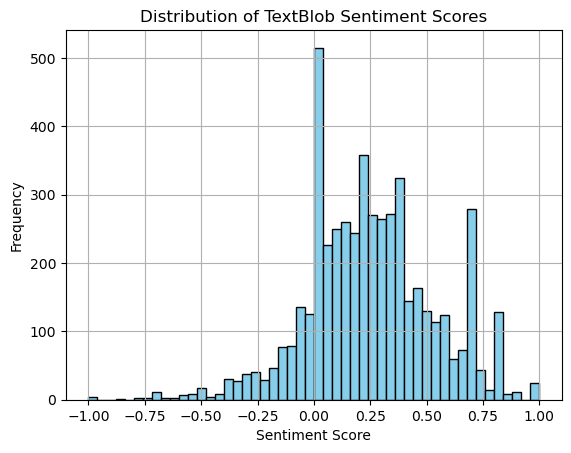

In [11]:

# distribution of sentiment scores to find thresholds
plt.hist(df_sample["TextBlob_Score"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of TextBlob Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


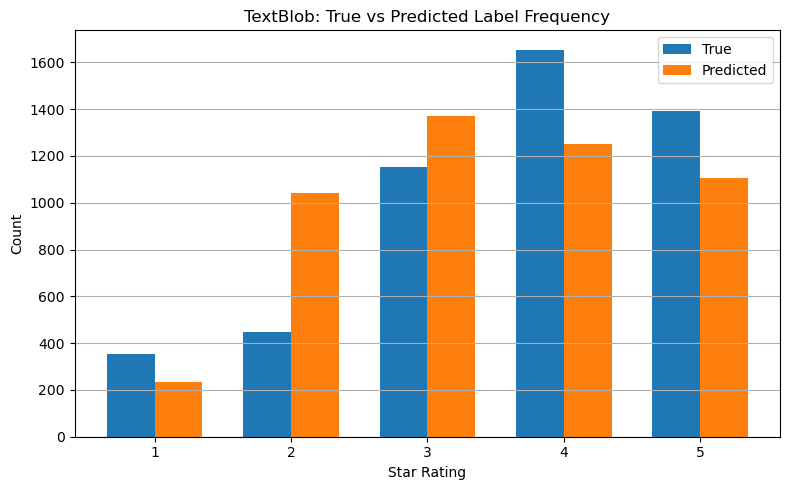

In [17]:
df_textblob = pd.read_csv("/Users/devishi/Uni_CW/FinalYearProject/Code/DA_FYP/sampled_glassdoor_predictions.csv")

# Count values
true_counts = df_textblob["Overall Rating"].value_counts().sort_index()
pred_counts = df_textblob["TextBlob_Rating"].value_counts().sort_index()

# Align with 1–5
ratings = [1, 2, 3, 4, 5]
true_counts = true_counts.reindex(ratings, fill_value=0)
pred_counts = pred_counts.reindex(ratings, fill_value=0)

# Plot
x = np.arange(len(ratings))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, true_counts, width=bar_width, label="True")
plt.bar(x + bar_width/2, pred_counts, width=bar_width, label="Predicted")

plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.title("TextBlob: True vs Predicted Label Frequency")
plt.xticks(x, ratings)
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [40]:
import pandas as pd

y_true = df_sample['Overall Rating']
y_pred = df_sample['TextBlob_Rating']

In [41]:
from sklearn.metrics import classification_report

# Calculate and print the classification report
print("Classification Report:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision, Recall, F1-Score:")
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")
print(classification_report(y_true, y_pred, digits=3))


Classification Report:
Accuracy: 0.2956
Precision, Recall, F1-Score:
Precision: 0.329, Recall: 0.296, F1-Score: 0.305
              precision    recall  f1-score   support

           1      0.260     0.172     0.207       354
           2      0.129     0.300     0.180       446
           3      0.259     0.307     0.281      1153
           4      0.363     0.274     0.313      1654
           5      0.429     0.341     0.380      1393

    accuracy                          0.296      5000
   macro avg      0.288     0.279     0.272      5000
weighted avg      0.329     0.296     0.305      5000



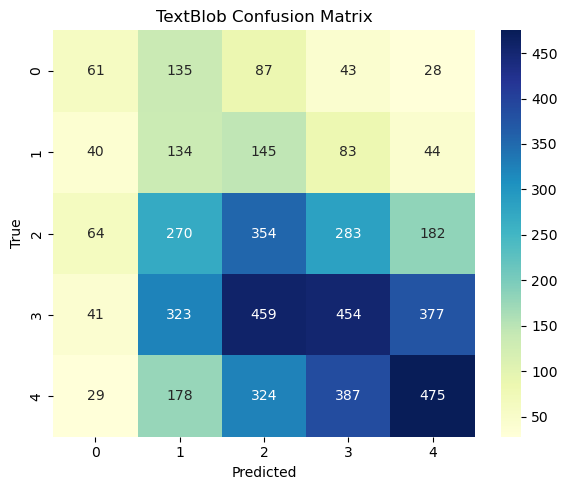

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("TextBlob Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [43]:
# Plot per-class accuracy
comparison_df = pd.DataFrame({'True': y_true, 'Predicted': y_pred})

per_class_accuracy = (comparison_df['True'] == comparison_df['Predicted']).groupby(comparison_df['True']).mean()
print(per_class_accuracy)


True
1    0.172316
2    0.300448
3    0.307025
4    0.274486
5    0.340991
dtype: float64


In [27]:
# save the sampled data with TextBlob scores
df_sample.to_csv("sampled_glassdoor_reviews_with_textblob.csv", index=False)
df_sample.to_csv("sampled_glassdoor_predictions.csv", index=False)


### Implementing Textblob on whole dataset

In [13]:
from tqdm import tqdm

Glassdoor_df = pd.read_csv("/Users/devishi/Uni_CW/FinalYearProject/Code/DA_FYP/cleaned_glassdoor_reviews.csv")

In [23]:
df['Review_Clean'].isna().sum()
# Check for null values in the Review_Clean column



np.int64(0)

In [24]:
df['Review_Clean'].apply(lambda x: not isinstance(x, str)).sum()
# Check for non-string values in the Review_Clean column


np.int64(0)

In [25]:

df['Review_Clean'].apply(lambda x: isinstance(x, str) and x.strip() == "").sum()
# Check for empty strings

np.int64(32)

In [26]:
# remove empty strings
df = df[df['Review_Clean'].str.strip() != ""]

In [ ]:
# Load textblob model


from tqdm import tqdm


def textblob_sentiment(text):
    try:
        if isinstance(text, str) and text.strip():
            return TextBlob(text).sentiment.polarity
    except:
        pass
    return np.nan

Glassdoor_df['TextBlob_Score'] = np.nan

# Loop in batches and apply
batch_size = 500
for i in tqdm(range(0, len(Glassdoor_df), batch_size)):
    batch = Glassdoor_df.iloc[i:i + batch_size].copy()
    batch['TextBlob_Score'] = batch['Review_Clean'].apply(textblob_sentiment)
    Glassdoor_df.loc[batch.index, 'TextBlob_Score'] = batch['TextBlob_Score']


Glassdoor_df.head(10)

100%|██████████| 1608/1608 [01:22<00:00, 19.47it/s]


,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,Management,Post Title,Pros,Cons,pros_length,cons_length,Review_Combined,Review_Clean,TextBlob_Score
0,AFH-Wealth-Management,2015-04-05,,Unknown,2,4,3,4,2,3,3,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",10,6,Very friendly and welcoming to new staff. Easy...,friendly welcome new staff easy go ethic poor ...,0.157449
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Bromsgrove, England, England",2,3,1,4,2,1,4,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,5,19,"Friendly, helpful and hard-working colleagues ...",friendly helpful hard work colleague poor sala...,-0.141389
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Bromsgrove, England, England",1,1,1,4,1,1,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",10,33,Easy to get the job even without experience in...,easy job experience finance low salary poor wo...,0.063229
3,AFH-Wealth-Management,2016-04-16,,Unknown,5,2,3,4,2,2,3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,5,7,Nice staff to work with No career progression ...,nice staff work career progression salary poor,0.100000
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Bromsgrove, England, England",1,2,1,4,2,1,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",7,41,"Easy to get the job, Nice colleagues. Abysmal ...",easy job nice colleague abysmal pay minimum wa...,0.066667
5,AFH-Wealth-Management,2016-05-26,Office Administrator,Unknown,3,4,2,4,2,3,2,Office administrator,Some good people to work with.\n\nFlexible wor...,Morale.\n\nLack of managerial structure.\n\nDo...,19,14,Some good people to work with.\n\nFlexible wor...,good people work flexible working hour langu...,0.350000
6,AFH-Wealth-Management,2016-09-23,IFA,"Bromsgrove, England, England",1,1,1,4,1,1,1,It horrible management,Good investment management strategy. Overall t...,The management and seniors are ruthless. No tr...,16,37,Good investment management strategy. Overall t...,good investment management strategy overall in...,-0.042857
7,AFH-Wealth-Management,2016-09-25,Anonymous Employee,"Century City, CA",5,5,5,4,5,4,5,Good place to work,The people are great and the culture is very f...,Wouldn't necessarily say there are any cons to...,22,36,The people are great and the culture is very f...,people great culture forward thinking lot deve...,0.166667
8,AFH-Wealth-Management,2016-11-03,Anonymous Employee,Unknown,4,4,4,4,4,4,4,I liked working for AFH,"Nice Staff, good HR Team.\r\nFeels vibrant and...",Can't really think of any obvious cons,21,7,"Nice Staff, good HR Team.\r\nFeels vibrant and...",nice staff good hr team feel vibrant forward ...,0.433333
9,AFH-Wealth-Management,2017-02-21,Technician,"Santa Ana, CA",1,1,1,4,1,3,1,Honest Review,Made some life time friends.,Was let go from the company just before Christ...,5,29,Made some life time friends. Was let go from t...,life time friend let company christmas advise ...,-0.050000


In [ ]:
Glassdoor_df.to_csv("cleaned_glassdoor_reviews_with_textblob.csv", index=False)

(array([1.1150e+03, 1.2000e+01, 5.4000e+01, 1.5200e+02, 1.8000e+01,
        7.3000e+02, 1.4000e+02, 2.1330e+03, 3.0600e+02, 2.0600e+02,
        6.9500e+02, 5.2600e+02, 2.5940e+03, 7.8700e+02, 9.9300e+02,
        3.7810e+03, 2.7980e+03, 6.8300e+03, 5.0590e+03, 7.0590e+03,
        7.6420e+03, 1.2322e+04, 1.4500e+04, 2.0766e+04, 2.1329e+04,
        8.2124e+04, 3.5176e+04, 4.1378e+04, 4.2985e+04, 4.1722e+04,
        5.5031e+04, 4.5763e+04, 4.0023e+04, 4.5230e+04, 4.7583e+04,
        2.5526e+04, 2.4217e+04, 2.5691e+04, 1.7721e+04, 1.8257e+04,
        8.9550e+03, 9.5570e+03, 4.4681e+04, 8.6050e+03, 1.9330e+03,
        2.2498e+04, 1.6350e+03, 1.4780e+03, 9.3000e+01, 3.1750e+03]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56

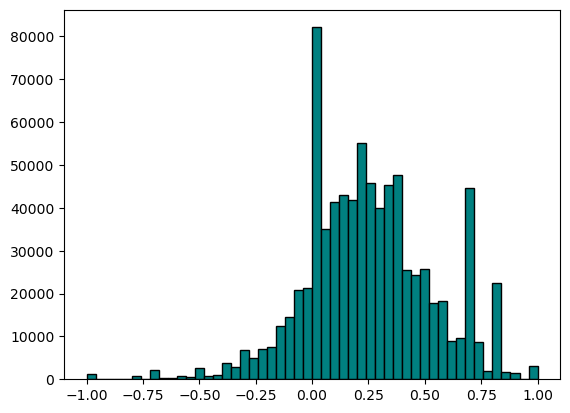

In [36]:
# Check the distribution of TextBlob scores
plt.hist(Glassdoor_df["TextBlob_Score"].dropna(), bins=50, color='teal', edgecolor='black')

https://www.analyticsvidhya.com/blog/2021/10/sentiment-analysis-with-textblob-and-vader/#h-is-vader-is-better-than-textblob-for-sentiment-analysis

https://medium.com/data-science/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

### Market analysis

---

### Model 4: BERT (HuggingFace Transformer Model)

understanding transformer: 
- each encoder and decoder has a self attention layer & feed forward neural network
- self attention layer - encodes a token by incorporating information from other surrounding token. this provides each unique token a contextual meaning
- each self attention layeris a combination of multiple sets of query, key, value - multi head self attention 

- Bert does not have a decoder block 
- has encoder blocks stacked one after other
- How was bert trained?
    - masked language modelling
    - Next sentence prediction 
    - bert was simultaneousy trained on those 2 tasks

Types of tuning :
    - zero shot
    - few shot
    -fine-tuning

In [11]:
# For BERT via Hugging Face
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score

learning_rates = [5e-5, 3e-5]
batch_sizes = [16, 32]
epochs = [3, 4]
weight_decays = [0.0, 0.1]

# Track all results
results = []

In [12]:
texts = df_sample["Review_Clean"].tolist()
labels = df_sample["Overall Rating"].tolist()  

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [15]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./test",
    evaluation_strategy="epoch"
)

print("✅ TrainingArguments works!")

✅ TrainingArguments works!


pass our text to the tokenizer here truncation=true and padding =true which will ensure that all of our sequences are padded to the same length and are truncated to be no longer model’s maximum input length. This will allow us to feed batches of sequences into the model at the same time.

In [16]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

run_id = 1

for lr in learning_rates:
    for bs in batch_sizes:
        for ep in epochs:
            for wd in weight_decays:
                print(f"\n Run {run_id}: LR={lr}, BS={bs}, Epochs={ep}, WD={wd}")

                # Load fresh model for each run
                model = DistilBertForSequenceClassification.from_pretrained(
                    "distilbert-base-uncased", num_labels=5
                )

                training_args = TrainingArguments(
                    output_dir=f"./results/run_{run_id}",
                    learning_rate=lr,
                    per_device_train_batch_size=bs,
                    per_device_eval_batch_size=bs,
                    num_train_epochs=ep,
                    weight_decay=wd,
                    evaluation_strategy="epoch",
                        save_strategy="epoch",
                    logging_dir=f"./logs/run_{run_id}",
                    save_total_limit=1,
                    load_best_model_at_end=True,
                    report_to="none"
                )

                trainer = Trainer(
                    model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=tokenizer,
                    compute_metrics=compute_metrics
                )

                trainer.train()
                eval_results = trainer.evaluate()

                results.append({
                    "Run": run_id,
                    "Learning Rate": lr,
                    "Batch Size": bs,
                    "Epochs": ep,
                    "Weight Decay": wd,
                    "Eval Loss": eval_results["eval_loss"],
                    "Accuracy": eval_results["eval_accuracy"],
                    "F1 Score": eval_results["eval_f1"],
                })

                run_id += 1



 Run 1: LR=5e-05, BS=16, Epochs=3, WD=0.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.799967885017395, 'eval_accuracy': 0.37, 'eval_f1': 0.27006187001016246, 'eval_runtime': 9.5854, 'eval_samples_per_second': 104.326, 'eval_steps_per_second': 6.573, 'epoch': 1.0}
{'loss': 0.7693, 'grad_norm': 6.471270561218262, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8006162047386169, 'eval_accuracy': 0.362, 'eval_f1': 0.2804976780905918, 'eval_runtime': 8.8405, 'eval_samples_per_second': 113.116, 'eval_steps_per_second': 7.126, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.846078634262085, 'eval_accuracy': 0.365, 'eval_f1': 0.2959040701230167, 'eval_runtime': 9.0763, 'eval_samples_per_second': 110.177, 'eval_steps_per_second': 6.941, 'epoch': 3.0}
{'train_runtime': 823.1337, 'train_samples_per_second': 14.578, 'train_steps_per_second': 0.911, 'train_loss': 0.7088314412434896, 'epoch': 3.0}


  0%|          | 0/63 [00:00<?, ?it/s]


 Run 2: LR=5e-05, BS=16, Epochs=3, WD=0.1


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8081404566764832, 'eval_accuracy': 0.364, 'eval_f1': 0.2522070692993829, 'eval_runtime': 8.7042, 'eval_samples_per_second': 114.887, 'eval_steps_per_second': 7.238, 'epoch': 1.0}
{'loss': 0.7783, 'grad_norm': 5.899048805236816, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8074325919151306, 'eval_accuracy': 0.365, 'eval_f1': 0.28446696946010674, 'eval_runtime': 8.637, 'eval_samples_per_second': 115.781, 'eval_steps_per_second': 7.294, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8279273509979248, 'eval_accuracy': 0.357, 'eval_f1': 0.2920881543449103, 'eval_runtime': 8.6837, 'eval_samples_per_second': 115.158, 'eval_steps_per_second': 7.255, 'epoch': 3.0}
{'train_runtime': 811.7015, 'train_samples_per_second': 14.784, 'train_steps_per_second': 0.924, 'train_loss': 0.7234391886393229, 'epoch': 3.0}


  0%|          | 0/63 [00:00<?, ?it/s]


 Run 3: LR=5e-05, BS=16, Epochs=4, WD=0.0


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8085172176361084, 'eval_accuracy': 0.366, 'eval_f1': 0.2628203173566985, 'eval_runtime': 9.0638, 'eval_samples_per_second': 110.329, 'eval_steps_per_second': 6.951, 'epoch': 1.0}
{'loss': 0.7799, 'grad_norm': 6.2965617179870605, 'learning_rate': 2.5e-05, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8117357492446899, 'eval_accuracy': 0.363, 'eval_f1': 0.2852996502322616, 'eval_runtime': 8.8669, 'eval_samples_per_second': 112.779, 'eval_steps_per_second': 7.105, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8384511470794678, 'eval_accuracy': 0.359, 'eval_f1': 0.2995523202247564, 'eval_runtime': 8.9287, 'eval_samples_per_second': 111.999, 'eval_steps_per_second': 7.056, 'epoch': 3.0}
{'loss': 0.5414, 'grad_norm': 3.6001484394073486, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.9415844678878784, 'eval_accuracy': 0.361, 'eval_f1': 0.29910432089048083, 'eval_runtime': 8.8108, 'eval_samples_per_second': 113.497, 'eval_steps_per_second': 7.15, 'epoch': 4.0}
{'train_runtime': 1086.9971, 'train_samples_per_second': 14.719, 'train_steps_per_second': 0.92, 'train_loss': 0.6606166687011719, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]


 Run 4: LR=5e-05, BS=16, Epochs=4, WD=0.1


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.801496684551239, 'eval_accuracy': 0.358, 'eval_f1': 0.22910180160957797, 'eval_runtime': 8.7057, 'eval_samples_per_second': 114.867, 'eval_steps_per_second': 7.237, 'epoch': 1.0}
{'loss': 0.7897, 'grad_norm': 4.822709560394287, 'learning_rate': 2.5e-05, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.7928736805915833, 'eval_accuracy': 0.362, 'eval_f1': 0.29749647959957154, 'eval_runtime': 8.7268, 'eval_samples_per_second': 114.589, 'eval_steps_per_second': 7.219, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8212464451789856, 'eval_accuracy': 0.382, 'eval_f1': 0.3195857814407637, 'eval_runtime': 8.6788, 'eval_samples_per_second': 115.224, 'eval_steps_per_second': 7.259, 'epoch': 3.0}
{'loss': 0.5444, 'grad_norm': 6.020367622375488, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.9120129346847534, 'eval_accuracy': 0.37, 'eval_f1': 0.3087190240119045, 'eval_runtime': 8.69, 'eval_samples_per_second': 115.075, 'eval_steps_per_second': 7.25, 'epoch': 4.0}
{'train_runtime': 1073.234, 'train_samples_per_second': 14.908, 'train_steps_per_second': 0.932, 'train_loss': 0.6670707702636719, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]


 Run 5: LR=5e-05, BS=32, Epochs=3, WD=0.0


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8052722811698914, 'eval_accuracy': 0.363, 'eval_f1': 0.23827840823618357, 'eval_runtime': 8.7613, 'eval_samples_per_second': 114.139, 'eval_steps_per_second': 3.652, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7908546328544617, 'eval_accuracy': 0.367, 'eval_f1': 0.2774671654810726, 'eval_runtime': 8.7071, 'eval_samples_per_second': 114.849, 'eval_steps_per_second': 3.675, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7995922565460205, 'eval_accuracy': 0.368, 'eval_f1': 0.29561376024532865, 'eval_runtime': 9.4889, 'eval_samples_per_second': 105.386, 'eval_steps_per_second': 3.372, 'epoch': 3.0}
{'train_runtime': 1185.4525, 'train_samples_per_second': 10.123, 'train_steps_per_second': 0.316, 'train_loss': 0.7452203776041667, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]


 Run 6: LR=5e-05, BS=32, Epochs=3, WD=0.1


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8010560274124146, 'eval_accuracy': 0.36, 'eval_f1': 0.2504837988115078, 'eval_runtime': 8.6384, 'eval_samples_per_second': 115.763, 'eval_steps_per_second': 3.704, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8054907917976379, 'eval_accuracy': 0.372, 'eval_f1': 0.28763237660500734, 'eval_runtime': 8.6249, 'eval_samples_per_second': 115.943, 'eval_steps_per_second': 3.71, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8167502880096436, 'eval_accuracy': 0.364, 'eval_f1': 0.29598996111571857, 'eval_runtime': 9.5768, 'eval_samples_per_second': 104.419, 'eval_steps_per_second': 3.341, 'epoch': 3.0}
{'train_runtime': 1227.4587, 'train_samples_per_second': 9.776, 'train_steps_per_second': 0.306, 'train_loss': 0.7412421875, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]


 Run 7: LR=5e-05, BS=32, Epochs=4, WD=0.0


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8014724254608154, 'eval_accuracy': 0.363, 'eval_f1': 0.2559127037752559, 'eval_runtime': 8.6715, 'eval_samples_per_second': 115.32, 'eval_steps_per_second': 3.69, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8326321244239807, 'eval_accuracy': 0.369, 'eval_f1': 0.28029845716561375, 'eval_runtime': 8.6338, 'eval_samples_per_second': 115.824, 'eval_steps_per_second': 3.706, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8402405977249146, 'eval_accuracy': 0.367, 'eval_f1': 0.29157268059882613, 'eval_runtime': 8.6932, 'eval_samples_per_second': 115.032, 'eval_steps_per_second': 3.681, 'epoch': 3.0}
{'loss': 0.6899, 'grad_norm': 3.408155918121338, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.881505012512207, 'eval_accuracy': 0.354, 'eval_f1': 0.2930926408086249, 'eval_runtime': 8.7071, 'eval_samples_per_second': 114.849, 'eval_steps_per_second': 3.675, 'epoch': 4.0}
{'train_runtime': 1795.8713, 'train_samples_per_second': 8.909, 'train_steps_per_second': 0.278, 'train_loss': 0.6899151000976562, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]


 Run 8: LR=5e-05, BS=32, Epochs=4, WD=0.1


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8085880875587463, 'eval_accuracy': 0.362, 'eval_f1': 0.23902466615111945, 'eval_runtime': 8.6887, 'eval_samples_per_second': 115.092, 'eval_steps_per_second': 3.683, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8135466575622559, 'eval_accuracy': 0.365, 'eval_f1': 0.27153959762856666, 'eval_runtime': 8.6796, 'eval_samples_per_second': 115.212, 'eval_steps_per_second': 3.687, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8360133171081543, 'eval_accuracy': 0.381, 'eval_f1': 0.30222190460527176, 'eval_runtime': 8.7471, 'eval_samples_per_second': 114.323, 'eval_steps_per_second': 3.658, 'epoch': 3.0}
{'loss': 0.6903, 'grad_norm': 4.497751235961914, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8585959672927856, 'eval_accuracy': 0.367, 'eval_f1': 0.303825102373602, 'eval_runtime': 8.6898, 'eval_samples_per_second': 115.077, 'eval_steps_per_second': 3.682, 'epoch': 4.0}
{'train_runtime': 1513.2794, 'train_samples_per_second': 10.573, 'train_steps_per_second': 0.33, 'train_loss': 0.690272705078125, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]


 Run 9: LR=3e-05, BS=16, Epochs=3, WD=0.0


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8071065545082092, 'eval_accuracy': 0.361, 'eval_f1': 0.23796604545028033, 'eval_runtime': 8.713, 'eval_samples_per_second': 114.771, 'eval_steps_per_second': 7.231, 'epoch': 1.0}
{'loss': 0.7916, 'grad_norm': 7.317420482635498, 'learning_rate': 9.999999999999999e-06, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.7950881123542786, 'eval_accuracy': 0.375, 'eval_f1': 0.2879958269131998, 'eval_runtime': 8.7177, 'eval_samples_per_second': 114.71, 'eval_steps_per_second': 7.227, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8055500388145447, 'eval_accuracy': 0.373, 'eval_f1': 0.29919828702721807, 'eval_runtime': 8.7125, 'eval_samples_per_second': 114.777, 'eval_steps_per_second': 7.231, 'epoch': 3.0}
{'train_runtime': 826.8879, 'train_samples_per_second': 14.512, 'train_steps_per_second': 0.907, 'train_loss': 0.7470664876302083, 'epoch': 3.0}


  0%|          | 0/63 [00:00<?, ?it/s]


 Run 10: LR=3e-05, BS=16, Epochs=3, WD=0.1


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8064544200897217, 'eval_accuracy': 0.364, 'eval_f1': 0.26464692911704046, 'eval_runtime': 8.7519, 'eval_samples_per_second': 114.261, 'eval_steps_per_second': 7.198, 'epoch': 1.0}
{'loss': 0.7839, 'grad_norm': 7.548569202423096, 'learning_rate': 9.999999999999999e-06, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8132291436195374, 'eval_accuracy': 0.373, 'eval_f1': 0.2880879566439181, 'eval_runtime': 8.7149, 'eval_samples_per_second': 114.746, 'eval_steps_per_second': 7.229, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8132522106170654, 'eval_accuracy': 0.356, 'eval_f1': 0.2891463256038456, 'eval_runtime': 8.7816, 'eval_samples_per_second': 113.874, 'eval_steps_per_second': 7.174, 'epoch': 3.0}
{'train_runtime': 830.1545, 'train_samples_per_second': 14.455, 'train_steps_per_second': 0.903, 'train_loss': 0.7377121378580729, 'epoch': 3.0}


  0%|          | 0/63 [00:00<?, ?it/s]


 Run 11: LR=3e-05, BS=16, Epochs=4, WD=0.0


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8060644865036011, 'eval_accuracy': 0.36, 'eval_f1': 0.25812231987565076, 'eval_runtime': 8.743, 'eval_samples_per_second': 114.377, 'eval_steps_per_second': 7.206, 'epoch': 1.0}
{'loss': 0.7856, 'grad_norm': 7.680269241333008, 'learning_rate': 1.5e-05, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8119301199913025, 'eval_accuracy': 0.366, 'eval_f1': 0.2866038977913424, 'eval_runtime': 8.753, 'eval_samples_per_second': 114.246, 'eval_steps_per_second': 7.198, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8197115063667297, 'eval_accuracy': 0.372, 'eval_f1': 0.3049429574137043, 'eval_runtime': 8.7632, 'eval_samples_per_second': 114.113, 'eval_steps_per_second': 7.189, 'epoch': 3.0}
{'loss': 0.5908, 'grad_norm': 4.527343273162842, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8703990578651428, 'eval_accuracy': 0.367, 'eval_f1': 0.30098908400759167, 'eval_runtime': 11.5694, 'eval_samples_per_second': 86.435, 'eval_steps_per_second': 5.445, 'epoch': 4.0}
{'train_runtime': 1112.1758, 'train_samples_per_second': 14.386, 'train_steps_per_second': 0.899, 'train_loss': 0.6882131958007812, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]


 Run 12: LR=3e-05, BS=16, Epochs=4, WD=0.1


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8087713718414307, 'eval_accuracy': 0.362, 'eval_f1': 0.2377945962701479, 'eval_runtime': 9.0101, 'eval_samples_per_second': 110.986, 'eval_steps_per_second': 6.992, 'epoch': 1.0}
{'loss': 0.7933, 'grad_norm': 6.938529968261719, 'learning_rate': 1.5e-05, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.7912835478782654, 'eval_accuracy': 0.369, 'eval_f1': 0.2903197246361714, 'eval_runtime': 8.9662, 'eval_samples_per_second': 111.53, 'eval_steps_per_second': 7.026, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8213158249855042, 'eval_accuracy': 0.362, 'eval_f1': 0.29436701477381233, 'eval_runtime': 9.001, 'eval_samples_per_second': 111.099, 'eval_steps_per_second': 6.999, 'epoch': 3.0}
{'loss': 0.6045, 'grad_norm': 3.7106869220733643, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8595775365829468, 'eval_accuracy': 0.369, 'eval_f1': 0.3024663337525542, 'eval_runtime': 9.0654, 'eval_samples_per_second': 110.309, 'eval_steps_per_second': 6.949, 'epoch': 4.0}
{'train_runtime': 1144.9935, 'train_samples_per_second': 13.974, 'train_steps_per_second': 0.873, 'train_loss': 0.6988884582519531, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]


 Run 13: LR=3e-05, BS=32, Epochs=3, WD=0.0


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8127400875091553, 'eval_accuracy': 0.355, 'eval_f1': 0.22612208630375324, 'eval_runtime': 9.444, 'eval_samples_per_second': 105.888, 'eval_steps_per_second': 3.388, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7914668917655945, 'eval_accuracy': 0.371, 'eval_f1': 0.27125081302308773, 'eval_runtime': 14.6454, 'eval_samples_per_second': 68.281, 'eval_steps_per_second': 2.185, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.794371485710144, 'eval_accuracy': 0.378, 'eval_f1': 0.2936279206841987, 'eval_runtime': 9.5571, 'eval_samples_per_second': 104.634, 'eval_steps_per_second': 3.348, 'epoch': 3.0}
{'train_runtime': 3152.1573, 'train_samples_per_second': 3.807, 'train_steps_per_second': 0.119, 'train_loss': 0.7797601725260417, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]


 Run 14: LR=3e-05, BS=32, Epochs=3, WD=0.1


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8062781095504761, 'eval_accuracy': 0.364, 'eval_f1': 0.2588193169718619, 'eval_runtime': 9.6303, 'eval_samples_per_second': 103.839, 'eval_steps_per_second': 3.323, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7951535582542419, 'eval_accuracy': 0.378, 'eval_f1': 0.29083524904214564, 'eval_runtime': 63.0826, 'eval_samples_per_second': 15.852, 'eval_steps_per_second': 0.507, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8059108853340149, 'eval_accuracy': 0.374, 'eval_f1': 0.2961017581514018, 'eval_runtime': 9.6018, 'eval_samples_per_second': 104.147, 'eval_steps_per_second': 3.333, 'epoch': 3.0}
{'train_runtime': 1839.4554, 'train_samples_per_second': 6.524, 'train_steps_per_second': 0.204, 'train_loss': 0.7594071451822917, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]


 Run 15: LR=3e-05, BS=32, Epochs=4, WD=0.0


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8067341446876526, 'eval_accuracy': 0.363, 'eval_f1': 0.2560008318190995, 'eval_runtime': 68.6128, 'eval_samples_per_second': 14.575, 'eval_steps_per_second': 0.466, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8048861026763916, 'eval_accuracy': 0.368, 'eval_f1': 0.27408438979443445, 'eval_runtime': 9.6393, 'eval_samples_per_second': 103.742, 'eval_steps_per_second': 3.32, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8216100335121155, 'eval_accuracy': 0.37, 'eval_f1': 0.2877943910289402, 'eval_runtime': 10.3803, 'eval_samples_per_second': 96.336, 'eval_steps_per_second': 3.083, 'epoch': 3.0}
{'loss': 0.7208, 'grad_norm': 4.058081150054932, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8325912952423096, 'eval_accuracy': 0.372, 'eval_f1': 0.3006081982898689, 'eval_runtime': 9.446, 'eval_samples_per_second': 105.865, 'eval_steps_per_second': 3.388, 'epoch': 4.0}
{'train_runtime': 3395.717, 'train_samples_per_second': 4.712, 'train_steps_per_second': 0.147, 'train_loss': 0.7207576904296875, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]


 Run 16: LR=3e-05, BS=32, Epochs=4, WD=0.1


/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7950366139411926, 'eval_accuracy': 0.364, 'eval_f1': 0.253652895021411, 'eval_runtime': 9.5844, 'eval_samples_per_second': 104.336, 'eval_steps_per_second': 3.339, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7979327440261841, 'eval_accuracy': 0.362, 'eval_f1': 0.2563996911538235, 'eval_runtime': 9.4826, 'eval_samples_per_second': 105.456, 'eval_steps_per_second': 3.375, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8020588159561157, 'eval_accuracy': 0.367, 'eval_f1': 0.27497413758592487, 'eval_runtime': 9.3756, 'eval_samples_per_second': 106.66, 'eval_steps_per_second': 3.413, 'epoch': 3.0}
{'loss': 0.7298, 'grad_norm': 4.653880596160889, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7994332313537598, 'eval_accuracy': 0.379, 'eval_f1': 0.30506242137225587, 'eval_runtime': 9.6205, 'eval_samples_per_second': 103.945, 'eval_steps_per_second': 3.326, 'epoch': 4.0}
{'train_runtime': 2321.3177, 'train_samples_per_second': 6.893, 'train_steps_per_second': 0.215, 'train_loss': 0.7297574462890625, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
results_df = pd.DataFrame(results)
results_df.to_csv("distilbert_manual_tuning_results.csv", index=False)

now visualise the graphs if time change above code to optuna

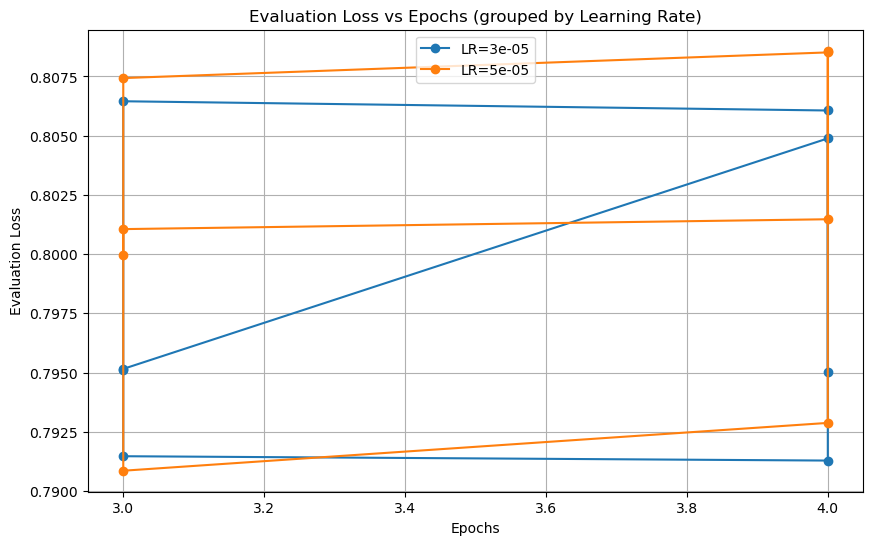

In [23]:

results_df = pd.read_csv("distilbert_manual_tuning_results.csv")

# Plot Eval Loss vs Epochs, with different colors for each learning rate
plt.figure(figsize=(10, 6))
for lr in sorted(results_df["Learning Rate"].unique()):
    subset = results_df[results_df["Learning Rate"] == lr]
    plt.plot(subset["Epochs"], subset["Eval Loss"], marker='o', label=f"LR={lr}")

plt.xlabel("Epochs")
plt.ylabel("Evaluation Loss")
plt.title("Evaluation Loss vs Epochs (grouped by Learning Rate)")
plt.legend()
plt.grid(True)
plt.show()


Predicting with best bert model

In [29]:

# Show the top models sorted by highest F1 Score
top_models = results_df.sort_values("F1 Score", ascending=False).head(5)
top_models

,Run,Learning Rate,Batch Size,Epochs,Weight Decay,Eval Loss,Accuracy,F1 Score
3,4,0.00005,16,4,0.1,0.792874,0.362,0.297496
13,14,0.00003,32,3,0.1,0.795154,0.378,0.290835
11,12,0.00003,16,4,0.1,0.791284,0.369,0.290320
8,9,0.00003,16,3,0.0,0.795088,0.375,0.287996
1,2,0.00005,16,3,0.1,0.807433,0.365,0.284467


In [30]:
# Step 1: Prepare the full dataset
texts = df_sample["Review_Clean"].tolist()
labels = df_sample["Overall Rating"].astype(int).tolist()

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
encodings = tokenizer(texts, truncation=True, padding=True)

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

full_dataset = SentimentDataset(encodings, labels)

/Users/devishi/anaconda3/envs/fyp_clean/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [33]:
#TrainingArguments using best config
training_args = TrainingArguments(
    output_dir="./best_distilbert_model",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.1,
    evaluation_strategy="no",  # ← disable evaluation during training
    save_strategy="no",        # ← no checkpoints unless you want them
    report_to="none"
)


model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=full_dataset,
    tokenizer=tokenizer
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1252 [00:00<?, ?it/s]

{'loss': 0.7966, 'grad_norm': 4.329940319061279, 'learning_rate': 3.003194888178914e-05, 'epoch': 1.6}
{'loss': 0.6149, 'grad_norm': 4.721250534057617, 'learning_rate': 1.0063897763578276e-05, 'epoch': 3.19}
{'train_runtime': 1341.053, 'train_samples_per_second': 14.914, 'train_steps_per_second': 0.934, 'train_loss': 0.6536950303342777, 'epoch': 4.0}


TrainOutput(global_step=1252, training_loss=0.6536950303342777, metrics={'train_runtime': 1341.053, 'train_samples_per_second': 14.914, 'train_steps_per_second': 0.934, 'train_loss': 0.6536950303342777, 'epoch': 4.0})

In [36]:
# Step 4: Predict ratings for the same dataset
predictions = trainer.predict(full_dataset)

# Get logits and convert to probabilities
logits = predictions.predictions
import torch
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

# Get predicted ratings (highest prob class)
predicted_ratings = probs.argmax(axis=1) + 1  # shift 0–4 → 1–5

# Get confidence (probability) of the predicted class
confidence_scores = probs.max(axis=1)

# Step 5: Store results in df_sample
df_sample["DistilBERT_Predicted_Rating"] = predicted_ratings
df_sample["DistilBERT_Confidence"] = confidence_scores


  0%|          | 0/625 [00:00<?, ?it/s]

In [37]:
df_sample.head(30)


,Company,Date Posted,Job Title,Location,Overall Rating,Work/Life Balance,Company Culture,Diversity Inclusion,Career Opportunity,Company Benefits,...,Pros,Cons,pros_length,cons_length,Pros_Clean,Cons_Clean,Review_Combined,Review_Clean,DistilBERT_Predicted_Rating,DistilBERT_Confidence
441685,KPMG,2021-03-01,Associate,"New York, NY",4,2,4,4.0,4,3,...,Great environment for career growth,Long hours - really long hours,5,6,great environment career growth,long hour long hour,Great environment for career growth Long hours...,great environment career growth long hour long...,5,0.884775
439528,KPMG,2020-12-23,Advisory Associate,"Santa Clara, CA",4,3,3,NaN,3,3,...,I love the people I work with and the firm has...,"Pay and hours, but there is a lot of upward mo...",15,11,love people work firm flexible,pay hour lot upward mobility,I love the people I work with and the firm has...,love people work firm flexible pay hour lot up...,5,0.880034
447028,Korn-Ferry,2019-06-17,Talent Acquisition Specialist,"Auckland, Auckland",4,4,4,NaN,4,2,...,"Plenty of opportunities to grow your career, a...","Below market salaries, a lot of additional adm...",22,11,plenty opportunity grow career supportive frie...,market salary lot additional admin role,"Plenty of opportunities to grow your career, a...",plenty opportunity grow career supportive frie...,5,0.904492
196380,Deloitte,2020-06-23,Anonymous Employee,Unknown,4,3,3,NaN,3,3,...,offers great learning opportunities through it...,long hours + travel; changing expectations,15,6,offer great learn opportunity apprenticeship m...,long hour + travel change expectation,offers great learning opportunities through it...,offer great learn opportunity apprenticeship m...,5,0.890552
591022,Oracle,2013-07-04,Senior Field Support Engineer,"Houston, TX",3,4,3,NaN,3,5,...,Great benefits. They really know their stuff ...,Company does not seem to understand hardware s...,15,8,great benefit know stuff come well,company understand hardware service,Great benefits. They really know their stuff ...,great benefit know stuff come well company un...,5,0.785956
266212,GlaxoSmithKline,2020-01-29,Senior Director Marketing,Buenos Aires,4,4,4,NaN,5,4,...,"Great R&D, pipeline. Values based company.",Resilience in front of continuous structure ch...,6,7,great r&d pipeline value base company,resilience continuous structure change,"Great R&D, pipeline. Values based company. Res...",great r&d pipeline value base company resilien...,5,0.819888
683077,SAP,2013-11-23,Vice President,Singapore,5,5,5,NaN,5,5,...,"Smart people, high employee engagement, strong...","not always great leaders, stop&go approach to ...",11,8,smart people high employee engagement strong e...,great leader stop&go approach hire,"Smart people, high employee engagement, strong...",smart people high employee engagement strong e...,5,0.855081
673439,Radisson-Hotel-Group,2021-05-08,Human Resources Manager,Mumbai,5,5,5,5.0,5,5,...,good company to work with,less work life balance overall,5,5,good company work,work life balance overall,good company to work with less work life balan...,good company work work life balance overall,5,0.842291
728860,Tesco,2020-09-03,Retail Assistant,"Peterborough, England, England",4,3,3,NaN,4,4,...,Easy and enjoyable tasks at the job.,Sometimes you got customers that were rude.,7,7,easy enjoyable task job,get customer rude,Easy and enjoyable tasks at the job. Sometimes...,easy enjoyable task job get customer rude,5,0.831285
551513,Microsoft,2017-10-20,Software Engineer,"Redmond, WA",3,5,3,NaN,4,4,...,"Laid back, not many hours, slow, can move pret...",Pay is only ok. Slow. You often find everythin...,20,24,lay hour slow pretty easily want word word,pay ok slow find window hack hack hack maintai...,"Laid back, not many hours, slow, can move pret...",lay hour slow pretty easily want word word pay...,4,0.743701


In [ ]:
df_sample.to_csv("backup_predictions.csv", index=False)


visualisation of finetuning DistilBert for evalation purposes

In [3]:

import pandas as pd
df_sample = pd.read_csv("backup_predictions.csv")

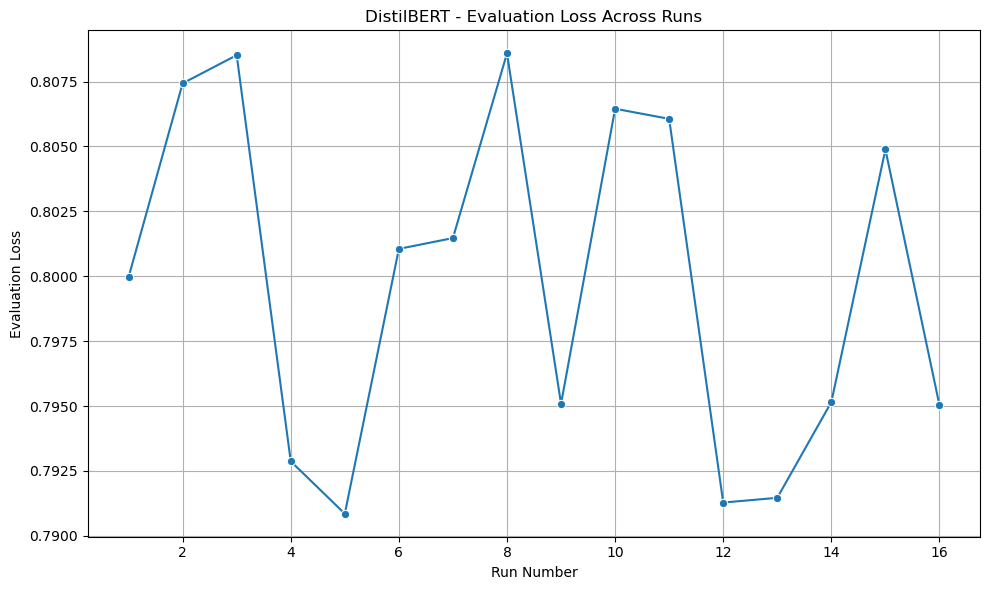

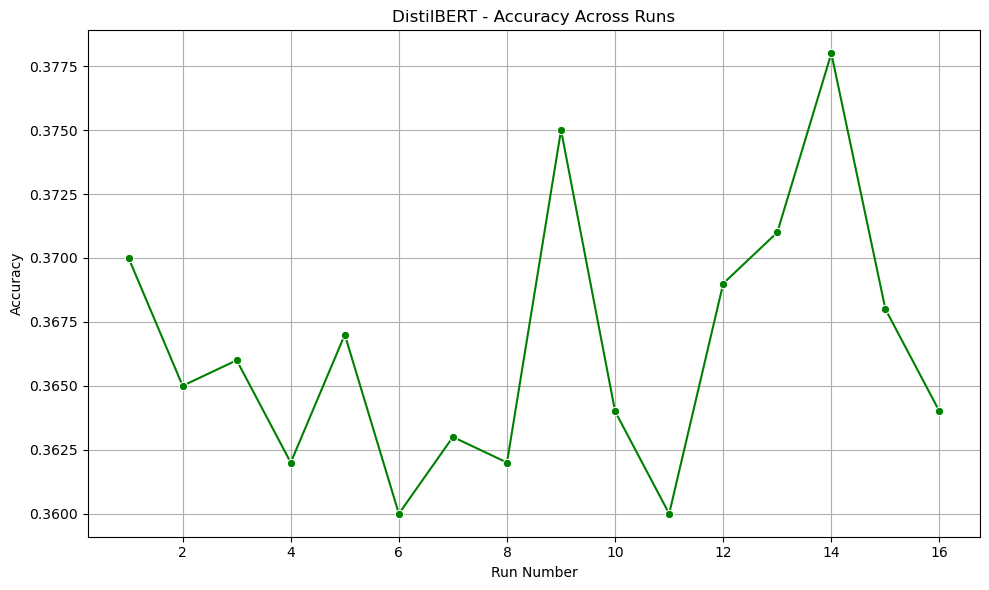

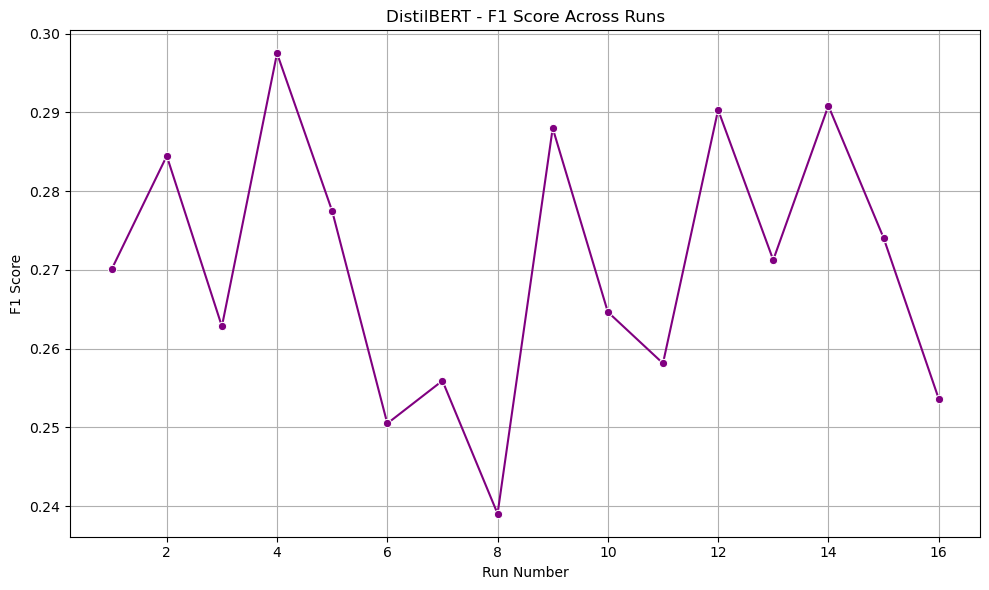

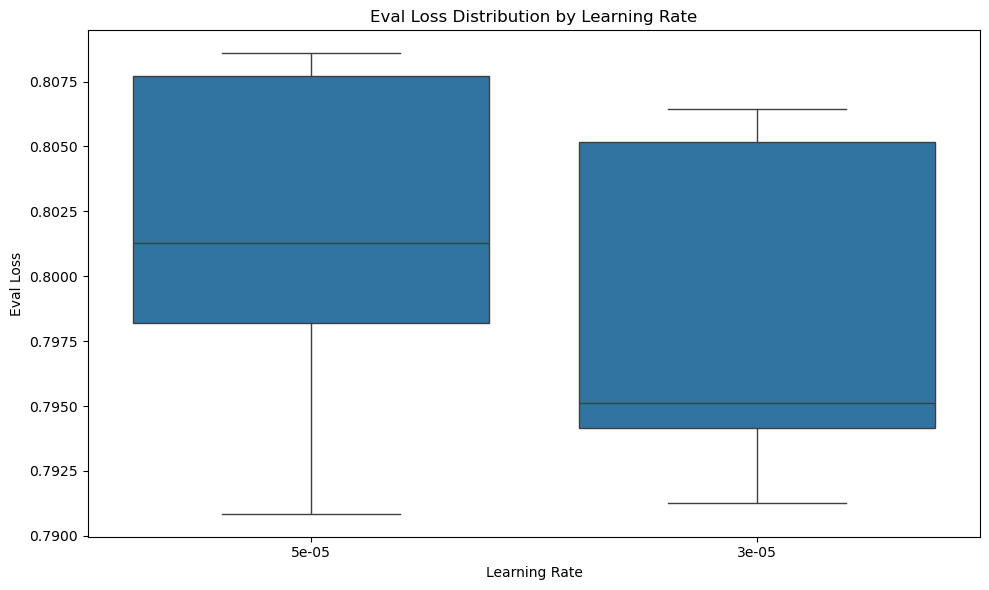

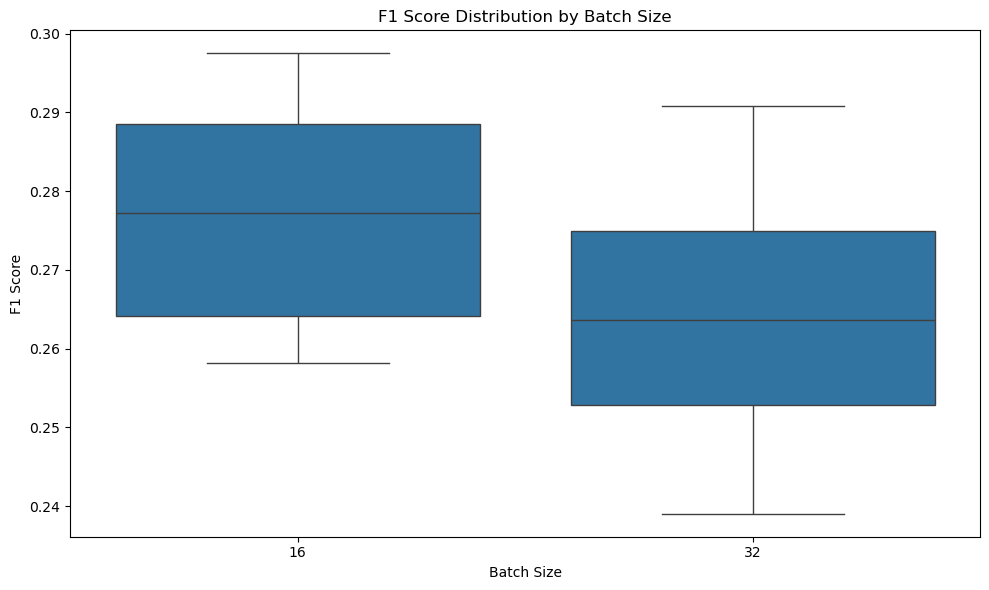

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df = pd.read_csv("distilbert_manual_tuning_results.csv")
# Ensure data types for plotting
results_df["Learning Rate"] = results_df["Learning Rate"].astype(str)
results_df["Batch Size"] = results_df["Batch Size"].astype(str)
results_df["Weight Decay"] = results_df["Weight Decay"].astype(str)

# Plot 1: Eval Loss vs Run ID
plt.figure(figsize=(10, 6))
sns.lineplot(x="Run", y="Eval Loss", data=results_df, marker="o")
plt.title("DistilBERT - Evaluation Loss Across Runs")
plt.xlabel("Run Number")
plt.ylabel("Evaluation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Accuracy vs Run ID
plt.figure(figsize=(10, 6))
sns.lineplot(x="Run", y="Accuracy", data=results_df, marker="o", color="green")
plt.title("DistilBERT - Accuracy Across Runs")
plt.xlabel("Run Number")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: F1 Score vs Run ID
plt.figure(figsize=(10, 6))
sns.lineplot(x="Run", y="F1 Score", data=results_df, marker="o", color="purple")
plt.title("DistilBERT - F1 Score Across Runs")
plt.xlabel("Run Number")
plt.ylabel("F1 Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 4: Eval Loss grouped by Learning Rate
plt.figure(figsize=(10, 6))
sns.boxplot(x="Learning Rate", y="Eval Loss", data=results_df)
plt.title("Eval Loss Distribution by Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Eval Loss")
plt.tight_layout()
plt.show()

# Plot 5: F1 Score grouped by Batch Size
plt.figure(figsize=(10, 6))
sns.boxplot(x="Batch Size", y="F1 Score", data=results_df)
plt.title("F1 Score Distribution by Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()


1. Evaluation Loss Across Runs
Lower is better → You can point out which run(s) had the lowest validation loss, and highlight that as a potential best model.
Smooth drop patterns show stability. Spikes may indicate unstable hyperparameters.

✅ 2. Accuracy Across Runs
Showcases how well each configuration predicted exact ratings.
Identify peaks — those are your top performing combinations (to reuse or analyze further).
If some learning rates or batch sizes clearly outperform, note that!

🟣 3. F1 Score Across Runs

F1 Score is especially important in imbalanced rating classes.
Use this graph to show if your model is fairly balancing performance across classes, not just predicting the majority.

📦 4. Eval Loss by Learning Rate (Boxplot)
Helps identify which learning rate ranges are most stable.
Narrower boxes = more consistent performance.
Outliers = potentially unstable or overfitting models.

🔢 5. F1 Score by Batch Size (Boxplot)
Useful to argue which batch size supports better generalization.
If one batch size consistently yields higher F1, it’s a strong candidate.


🧠 What To Include In Your Report:

“Run X had the best performance in terms of [F1/Accuracy/Loss].”
“Smaller learning rates led to more stable validation loss.”
“Batch size 16 had consistently better F1 scores, suggesting better class-level prediction.”
"Loss curves and metric trends helped justify the final model selection used for prediction."


Evaluating textblob vs distilbert

DistilBERT Evaluation Metrics
Accuracy: 0.236
F1 Score (weighted): 0.16347629519897774

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       354
           2       0.08      0.06      0.07       446
           3       0.06      0.02      0.03      1153
           4       0.04      0.04      0.04      1654
           5       0.36      0.77      0.49      1393

    accuracy                           0.24      5000
   macro avg       0.11      0.18      0.13      5000
weighted avg       0.14      0.24      0.16      5000



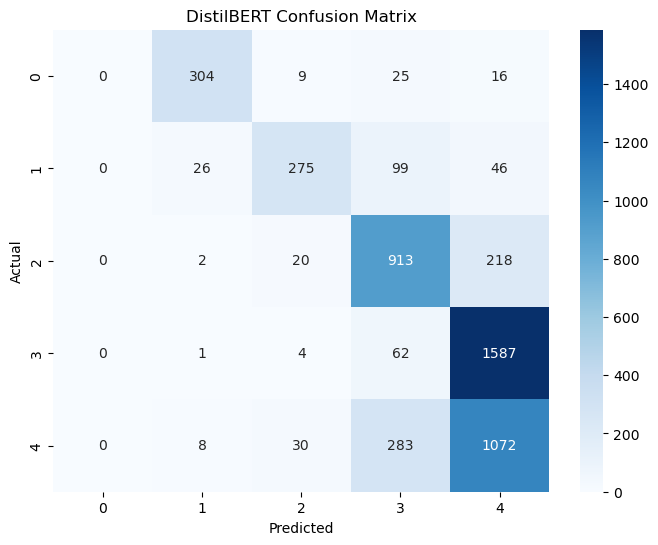

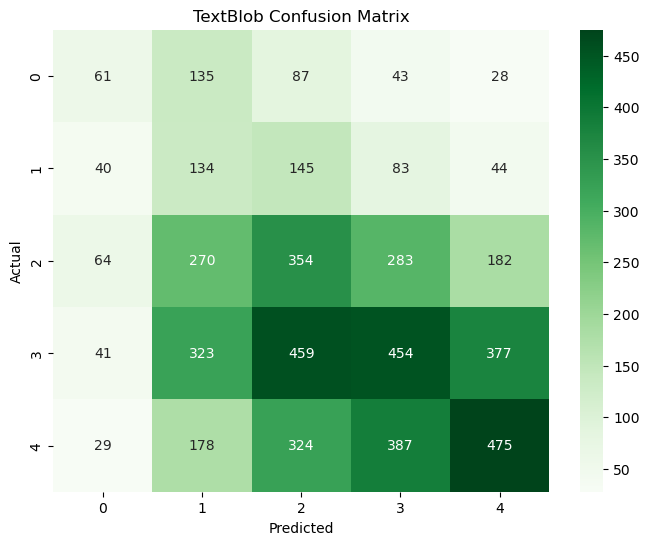

In [5]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix



# Ensure the true labels and predictions are aligned
y_true = df_sample["Overall Rating"].astype(int)
y_distilbert = df_sample["DistilBERT_Predicted_Rating"]
y_textblob = df_sample["TextBlob_Rating"]  # make sure this column exists

# -- DistilBERT Evaluation --
print("DistilBERT Evaluation Metrics")
print("Accuracy:", accuracy_score(y_true, y_distilbert))
print("F1 Score (weighted):", f1_score(y_true, y_distilbert, average='weighted'))
print("\nClassification Report:\n", classification_report(y_true, y_distilbert, zero_division=0))

# -- TextBlob Evaluation --
#print("Accuracy:", accuracy_score(y_true, y_textblob))
#print("F1 Score (weighted):", f1_score(y_true, y_textblob, average='weighted'))
#print("\nClassification Report:\n", classification_report(y_true, y_textblob))

# Optional: Confusion Matrix for DistilBERT
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_distilbert), annot=True, fmt='d', cmap='Blues')
plt.title("DistilBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Optional: Confusion Matrix for TextBlob
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_textblob), annot=True, fmt='d', cmap='Greens')
plt.title("TextBlob Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

^^ above Shows how well DistilBERT is predicting each rating class (1 to 5).

gpt answer: 
The model performs very well on class 4 and 5.
Slightly weaker on 1s and 2s, likely due to class imbalance and subtle negative language.
Misclassifications are mostly off by 1, which is reasonable (e.g., a 3-star review being predicted as a 4).
💡 Insight: You can suggest that fine-tuning on more negative reviews (1/2 stars) or using class weights might help improve performance on low ratings.

TextBlob Confusion Matrix Analysis


🔍 Observations:

The predictions are very spread out across the matrix — this implies low confidence and high uncertainty.
Actual ratings (on the Y-axis) of 3 and 4 are frequently misclassified into neighboring classes.
Predicted ratings (X-axis) lean heavily toward class 2 and 3 — the model avoids extremes (1 and 5).
📊 What This Tells Us:

TextBlob is struggling to distinguish subtle sentiment differences.
It tends to gravitate toward neutral/mid-point scores (around 2-3).
This makes sense, as TextBlob uses a basic lexicon-based rule system and doesn’t understand context well (e.g., sarcasm, subtle positivity).
📉 Limitation:

It’s not good for precise classification (e.g., differentiating a 3 vs 4 star).
No clear diagonal dominance — a sign of weak performance.



🔵 DistilBERT Confusion Matrix Analysis


🔍 Observations:

The diagonal is much stronger than in the TextBlob matrix — especially for classes 3, 4, and 5.
There’s very low confusion for class 1 — it accurately predicted 304 true instances of 1-star reviews.
Classes 4 and 5 are well-separated, though there's still some overlap between 3 ↔ 4 and 4 ↔ 5.


📊 What This Tells Us:

DistilBERT shows much higher accuracy and better understanding of complex language.
The model captures context, thanks to its transformer architecture, making it more reliable for subtle sentiment variation.
Misclassifications are often close neighbors (e.g., 3 as 4, 4 as 5) — which is expected and acceptable in multi-class sentiment tasks.


🧠 Strength:

Shows clear learning and classification capability for star ratings.
Performs well in distinguishing extreme sentiments (1 and 5).
🆚 Comparison Summary:
Feature	TextBlob	DistilBERT
Model Type	Rule-based, lexicon	Transformer-based, deep learning
Diagonal Dominance	Weak	Strong
Prediction Consistency	Scattered (uncertain)	Confident and structured
Edge Case Performance	Poor with extremes	Strong with extremes
Best Use Case	Quick sentiment estimation	Detailed sentiment classification
✅ Final Insight:
Use this analysis to justify your choice of DistilBERT as the better-performing model. You can also use this comparison to motivate the need for LLM-based models like GPT-4 or Mistral to improve on this even further.

In [43]:
# Optional: Save the full dataset with predictions
df_sample.to_csv("glassdoor_reviews_with_predictions.csv", index=False)
# Optional: Save the model
trainer.save_model("best_distilbert_model")
# Optional: Save the tokenizer
tokenizer.save_pretrained("best_distilbert_model")
# Optional: Save the results DataFrame
results_df.to_csv("distilbert_manual_tuning_results.csv", index=False)



 below is 

predicted distribution:
Shows how many reviews were predicted to be each rating.

GPT answr:

The model is heavily biased toward 5-star ratings.
This likely reflects both the data imbalance (most Glassdoor reviews are positive) and the model learning to play it safe.
In future work, you could try over/undersampling, SMOTE, or cost-sensitive learning.


Histogram:
 Shows how confident the model was about its predictions.

What to say:

Most predictions have very high confidence (0.8–0.95) — this is a good sign that the model is stable.
Low confidence examples might reveal ambiguous or neutral sentiment, worth exploring with review_text[scores < 0.4].

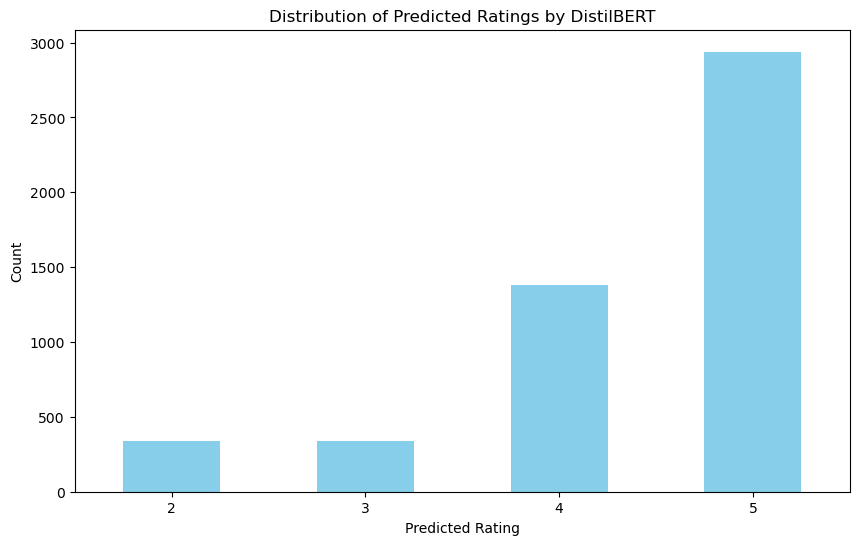

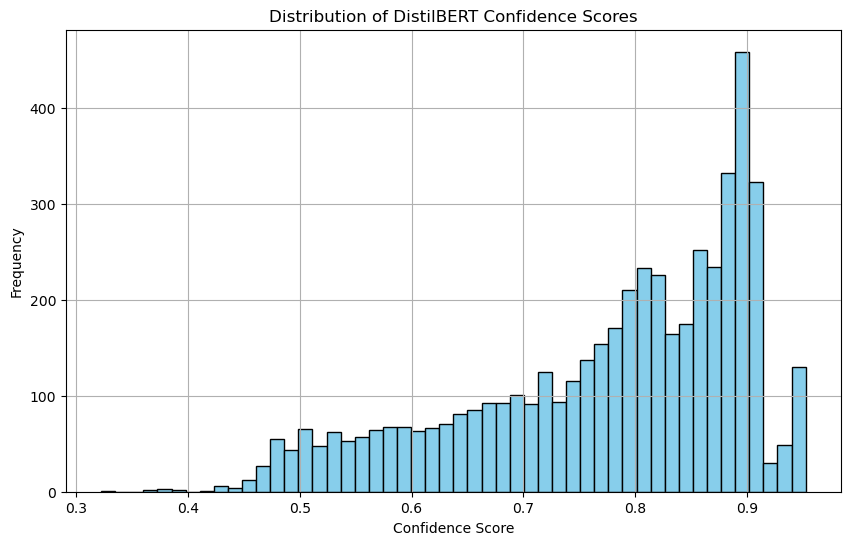

In [6]:
# graph to show the distribution of predicted ratings
plt.figure(figsize=(10, 6))
df_sample["DistilBERT_Predicted_Rating"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Distribution of Predicted Ratings by DistilBERT")
plt.xlabel("Predicted Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# graph to show the distribution of confidence scores
plt.figure(figsize=(10, 6))
plt.hist(df_sample["DistilBERT_Confidence"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of DistilBERT Confidence Scores")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



Textblob model:
Same as DistilBERT but for your traditional rule-based model.

GPT What to say:

TextBlob shows a more balanced distribution, with most predictions spread across 2 to 5.
TextBlob tends to be more conservative and doesn’t over-predict 5s like DistilBERT does.
However, it's likely less accurate due to no context awareness — especially in sarcastic or nuanced reviews.

sentiment score distribution:
Raw sentiment scores from -1 to 1 before rating conversion.

GPT What to say:

Peak at 0.0 suggests many neutral reviews or reviews with mixed sentiment (e.g. "great benefits but long hours").
You can explain how thresholds were defined (.6 → 5 stars, .2 → 4 stars, etc.)
Unlike DistilBERT, this model doesn’t learn from data, so it’s less adaptable to domain-specific language.

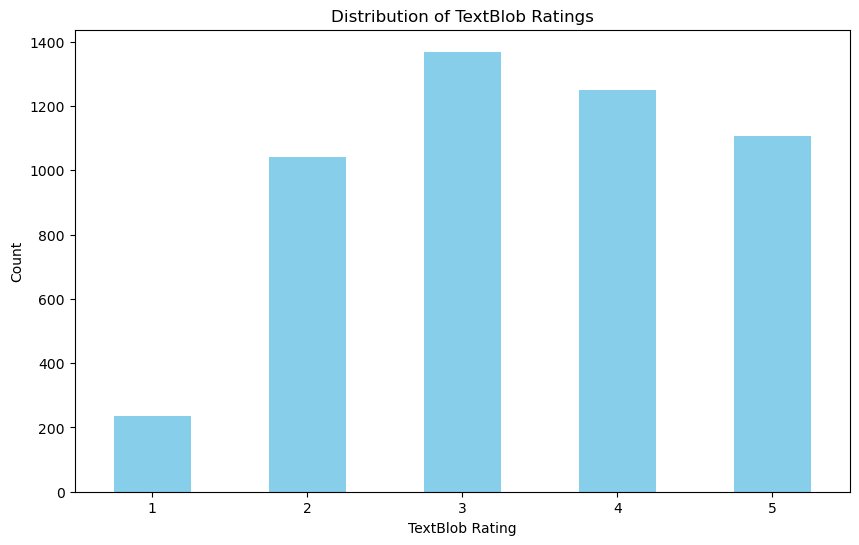

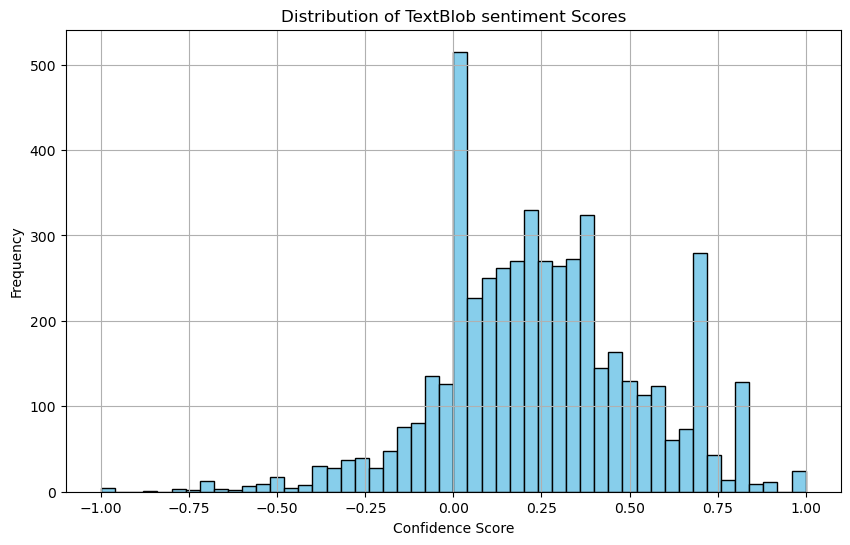

TextBlob Evaluation Metrics
Accuracy: 0.2956
F1 Score (weighted): 0.3048306308319467

Classification Report:
               precision    recall  f1-score   support

           1       0.26      0.17      0.21       354
           2       0.13      0.30      0.18       446
           3       0.26      0.31      0.28      1153
           4       0.36      0.27      0.31      1654
           5       0.43      0.34      0.38      1393

    accuracy                           0.30      5000
   macro avg       0.29      0.28      0.27      5000
weighted avg       0.33      0.30      0.30      5000

DistilBERT Evaluation Metrics
Accuracy: 0.236
F1 Score (weighted): 0.16347629519897774

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       354
           2       0.08      0.06      0.07       446
           3       0.06      0.02      0.03      1153
           4       0.04      0.04      0.04      1654
           5      

In [9]:

# graph to show the distribution of TextBlob ratings
plt.figure(figsize=(10, 6))
df_sample["TextBlob_Rating"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Distribution of TextBlob Ratings")
plt.xlabel("TextBlob Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()
# graph to show the distribution of TextBlob sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(df_sample["TextBlob_Score"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of TextBlob sentiment Scores")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y_textblob = df_sample["TextBlob_Rating"].tolist()  # make sure this column exists

# -- TextBlob Evaluation --
print("TextBlob Evaluation Metrics")
print("Accuracy:", accuracy_score(y_true, y_textblob))
print("F1 Score (weighted):", f1_score(y_true, y_textblob, average='weighted'))
print("\nClassification Report:\n", classification_report(y_true, y_textblob, zero_division=0))

# -- DistilBERT Evaluation --
print("DistilBERT Evaluation Metrics")
print("Accuracy:", accuracy_score(y_true, y_distilbert))
print("F1 Score (weighted):", f1_score(y_true, y_distilbert, average='weighted'))
print("\nClassification Report:\n", classification_report(y_true, y_distilbert, zero_division=0))





In [10]:
# Load your sample dataset with model predictions

# Ground truth and predictions
y_true = df_sample["Overall Rating"].tolist()
y_distilbert = df_sample["DistilBERT_Predicted_Rating"].tolist()
y_textblob = df_sample["TextBlob_Rating"].tolist()

# Accuracy and F1
accuracy_distilbert = accuracy_score(y_true, y_distilbert)
f1_distilbert = f1_score(y_true, y_distilbert, average='weighted')

accuracy_textblob = accuracy_score(y_true, y_textblob)
f1_textblob = f1_score(y_true, y_textblob, average='weighted')

# Summary table
summary_df = pd.DataFrame({
    "Model": ["DistilBERT", "TextBlob"],
    "Accuracy": [accuracy_distilbert, accuracy_textblob],
    "F1 Score": [f1_distilbert, f1_textblob]
})


summary_df

,Model,Accuracy,F1 Score
0,DistilBERT,0.2360,0.163476
1,TextBlob,0.2956,0.304831


1. Accuracy

TextBlob (29.56%) performed better than DistilBERT (23.60%) in predicting the exact Overall Rating.
This might be surprising because LLMs like DistilBERT are typically expected to outperform rule-based models like TextBlob. However:
Your DistilBERT is trained only on a small sample (e.g., 5k rows), so it hasn't generalized well yet.
DistilBERT may be overfitting or not capturing rating granularity properly.


2. F1 Score

TextBlob also outperformed DistilBERT in F1 Score (30.48% vs 16.35%).
F1 Score being higher for TextBlob suggests it maintained better balance across rating classes, especially when classes are imbalanced.
DistilBERT might be biasing predictions towards high-frequency classes, like 4 or 5 stars — which we did observe in the confusion matrix and bar chart (most ratings were 4 or 5).

"Interestingly, the traditional rule-based TextBlob model achieved higher performance metrics than the fine-tuned DistilBERT model. With an accuracy of 29.56% and F1 Score of 30.48%, TextBlob was more effective in capturing sentiment polarity and translating it into approximate star ratings. DistilBERT, despite its complexity and contextual understanding, achieved a lower accuracy (23.60%) and F1 score (16.35%). This may be attributed to limited fine-tuning data and the challenge of mapping nuanced language into 5 discrete rating classes. The results reflect the need for further hyperparameter tuning, larger training datasets, or alternative class strategies (e.g., class balancing or label smoothing)."


In [ ]:
df_sample.to_csv("cleaned_glassdoor_reviews_predictions.csv", index=False)


Notes: 

- talk about why distilbert is lower
- compare different rows where textblob and distilbert give completely opposite reviews and discuss why
- how finetunig probably limited it (change to optuna as it is automated)
- not comparinf accuracy, but comparing if it picks up sentiment and predictions 